# Optimizing garen builds #
This notebook will optimize garen builds for a some pre defined targets and constraints.

## Define functions that calculate ability damages

In [12]:
import pandas as pd
import numpy as np

def q_damage(
    q_level: int,
    stats: dict[str, float],
    target_armor: float = 0,
    target_magic_resistance: float = 0,
    crit_multiplier: float = 1.75,
    dmg_amp: float = 1
):
    q_level_damage = [30, 60, 90, 120, 150]
    q_damage = q_level_damage[q_level - 1] + stats["ad"] * 0.5
    crit_adjusted_q_damage = q_damage * (crit_multiplier * stats["crit_chance"] + (1-stats["crit_chance"]))
    return crit_adjusted_q_damage*dmg_amp

def e_turn_damage(
    e_level: int,
    stats: dict[str, float],
    target_armor: float = 0,
    target_magic_resistance: float = 0,
    crit_multiplier: float = 1.4,
    dmg_amp: float = 1 # if IE built then 1.72
    # reminder: if hit by e spins 6 times, armour is reduced by 25%
    # garen spins around 7 + 1 per 25% bonus attack speed times over 3 seconds
):
    e_level_damage_far = [4, 8, 12, 16, 20]
    e_level_ad_scaling_far = [0.36, 0.38, 0.4, 0.42, 0.44]
    e_level_damage_near = [5, 10, 15, 20, 25]
    e_level_ad_scaling_near = [0.45, 0.475, 0.5, 0.525, 0.55]

    e_near_dmg = e_level_damage_near[e_level - 1] + stats["ad"] * e_level_ad_scaling_near[e_level - 1]
    e_far_dmg = e_level_damage_far[e_level - 1] + stats["ad"] * e_level_ad_scaling_far[e_level - 1]
    
    e_array = np.array([e_near_dmg, e_far_dmg])
    crit_adjust = crit_multiplier * stats["crit_chance"] + (1-stats["crit_chance"])

    [near_dmg, far_dmg] = np.multiply(e_array, crit_adjust)

    return [dmg_amp*near_dmg, dmg_amp*far_dmg]

def get_total_spins(stats: dict[str, float]) -> int:
    bonus_as = stats['bonus_attack_speed']
    # Each 0.25 (25%) adds 1 spin
    extra_spins = int(bonus_as / 0.25)
    return 7 + extra_spins
    
def r_damage(
    r_level: int,
    percentage_dmg_multiplier: float,
    target_health: float,
    target_max_health: float,
    dmg_amp: float = 1
):
    r_level_damage = [150, 250, 350]
    r_level_punish = [0.25, 0.3, 0.35]
    missing_health = target_max_health - target_health
    r_damage = r_level_damage[r_level - 1] + percentage_dmg_multiplier * missing_health * r_level_punish[r_level - 1]
    return dmg_amp*r_damage

## Calculate base stats per level

In [13]:
def calculate_stat(base, growth, level):
    if level == 1:
        return base
    # Official League of Legends growth formula
    multiplier = (level - 1) * (0.7025 + 0.0175 * (level - 1))
    return round(base + growth * multiplier, 2)

levels = np.arange(1, 19)

garen_stats = pd.DataFrame({
    "level": levels,
    "ad": [calculate_stat(69, 4.5, lvl) for lvl in levels],
    "crit_chance": [0] * 18,
    "health": [calculate_stat(690, 98, lvl) for lvl in levels],
    "armor": [calculate_stat(38, 4.2, lvl) for lvl in levels],
    "magic_resistance": [calculate_stat(32, 1.55, lvl) for lvl in levels],
    "base_attack_speed": [0.625] * 18,
    "bonus_attack_speed": [round((lvl - 1) * (0.7025 + 0.0175 * (lvl - 1)) * 0.0365, 4) for lvl in levels]
})

garen_stats.head()

,level,ad,crit_chance,health,armor,magic_resistance,base_attack_speed,bonus_attack_speed
0,1,69.00,0,690.00,38.00,32.00,0.625,0.0000
1,2,72.24,0,760.56,41.02,33.12,0.625,0.0263
2,3,75.64,0,834.55,44.20,34.29,0.625,0.0538
3,4,79.19,0,911.97,47.51,35.51,0.625,0.0827
4,5,82.90,0,992.82,50.98,36.79,0.625,0.1128


In [14]:
# testing block
q_damage(q_level = 1, stats = garen_stats)

0      64.500
1      66.120
2      67.820
3      69.595
4      71.450
5      73.390
6      75.400
7      77.495
8      79.665
9      81.915
10     84.245
11     86.650
12     89.140
13     91.700
14     94.345
15     97.070
16     99.870
17    102.750
dtype: float64

# import item class from items.py and define the more commonly built items for Garen

In [15]:
from items import shop_item, active_item

beserkers_greaves = shop_item(
    name="Beserker's Greaves",
    price = 1100,
    stats = {
        "bonus_attack_speed": 0.25,
        "move_speed": 45,
    },
    item_type = "boots")

dorans_blade = shop_item(
    name="Doran's Blade",
    price = 450,
    stats = {
        "ad": 10,
        "health": 80,
    },
    item_type = "starter")

dorans_shield = shop_item(
    name="Doran's Shield",
    price = 450,
    stats = {
        "health": 110,
    },
    item_type = "starter")

phantom_dancer = shop_item(
    name="Phantom Dancer",
    price = 2650,
    stats = {
        "crit_chance": 0.25,
        "bonus_attack_speed": 0.6,
        "percent_move_speed": 0.08
    })

stride_breaker = active_item(
    name="Stride Breaker",
    price = 3300,
    stats = {
        "ad": 40,
        "health": 450,
        "bonus_attack_speed": 0.25
        # active damage = 0.4*ad
    },
    item_type = "cleave")

dead_mans_plate = shop_item(
    name="Dead Man's Plate",
    price=2900,
    stats={
        "health": 300,
        "armor": 45,
        "percent_move_speed": 0.05,
        "slow_resistance": 0.25
    })

infinity_edge = shop_item(
    name="Infinity Edge",
    price = 3450,
    stats = {
        "ad": 65,
        "crit_chance": 0.25
        # +40% crit damage
    })

black_cleaver = shop_item(
    name="Black Cleaver",
    price=3000,
    stats={
        "ad": 55,
        "health": 400,
        "haste": 20,
        "armor_shred_per_stack": 0.06, # Max 30% reduction (5 stacks)
    },
    item_type = "pen")

lord_dominiks_regards = shop_item(
    name="Lord Dominik's Regards",
    price=3200,
    stats={
        "ad": 45,
        "crit_chance": 0.25,
        "armor_pen": 0.35
    },
    item_type = "pen")

spear_of_shojin = shop_item(
    name="Spear of Shojin",
    price=3100,
    stats={
        "ad": 45,
        "health": 450
        # passive: 4 stacks, per stack 3% damage amplification
    },
    item_type = "pen")

trinity_force = shop_item(
    name="Trinity Force",
    price=3333,
    stats={
        "ad": 36,
        "bonus_attack_speed": 0.33,
        "health": 300,
        "haste": 20,
        "move_speed_on_hit": 20
        # Passive (Spellblade): Next attack deals 200% Base AD
        # Passive (Quicken): Basic attacks grant Move Speed
    },
    item_type = "sheen")

rapid_firecannon = shop_item(
    name="Rapid Firecannon",
    price=2600,
    stats={
        "bonus_attack_speed": 0.35,
        "crit_chance": 0.25,
        "percent_move_speed": 0.07,
        # Passive (Energized): Moving/Attacking generates a shock
        # Passive (Sniper): Increases range of Decisive Strike (Q) by 150
    })


### Define buy item function and test

In [16]:
def buy_item(base_stats_row, 
items: list[shop_item] = []):
    """
    Adds item stats to a specific level's base stats.
    Only adds stats that exist as columns in the base_stats_row.
    """
    new_stats = base_stats_row.copy()
    
    for item in items:
        for stat_name, value in item.stats.items():
            if stat_name in new_stats.index:
                new_stats[stat_name] += value
    if new_stats["crit_chance"] > 1:
        new_stats["crit_chance"] = 1

    return new_stats

lvl_11_base = garen_stats.iloc[10]
lvl_11_with_stride = buy_item(lvl_11_base, [stride_breaker])

print(f"Base AD at Lvl 11: {lvl_11_base['ad']}")
print(f"AD with Stridebreaker: {lvl_11_with_stride['ad']}")
print(q_damage(q_level = 1, stats = lvl_11_base))
print(q_damage(q_level = 1, stats = lvl_11_with_stride))

Base AD at Lvl 11: 108.49
AD with Stridebreaker: 148.49
84.245
104.245


## Start modelling

### Simple model (target dummy)
<ol>
<li>lvl 18, full 5 points in Q and E</li>
<li>can sell boots and doesn't have to buy stride breaker</li>
<li>target with no armor and no magic resistance</li>
<li>spellblade and % damage increase not considered</li>
</ol>

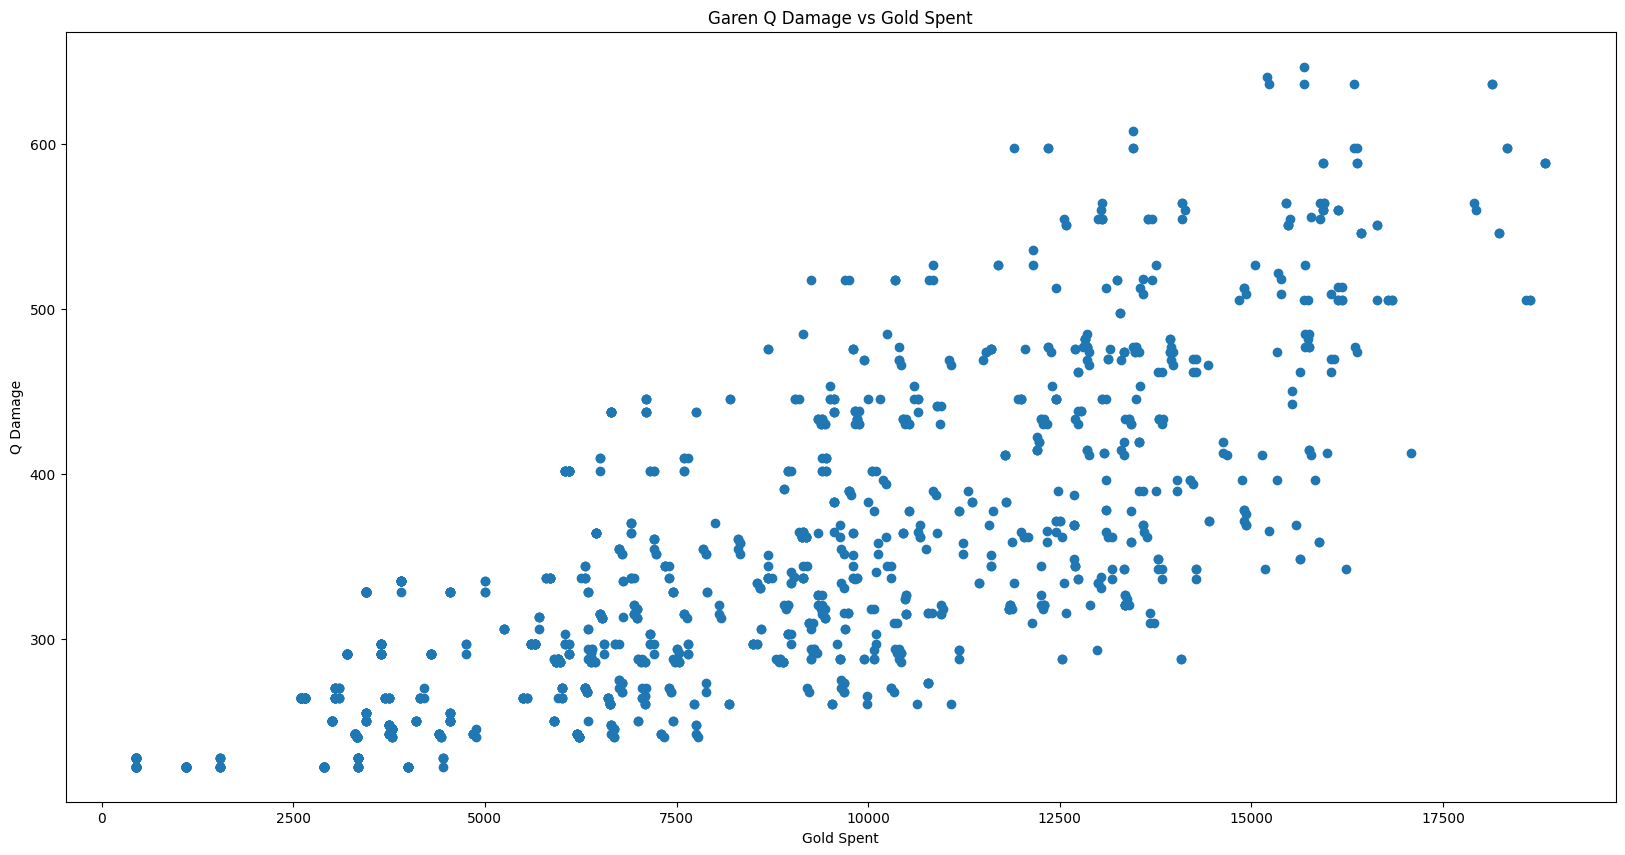

In [17]:
import matplotlib.pyplot as plt
import random


# Garen Level 18 Stats
BASE_AD_L18 = garen_stats.iloc[17]['ad']
items_pool = [
 stride_breaker, beserkers_greaves, dorans_blade, dorans_shield, dead_mans_plate, phantom_dancer, trinity_force,
 black_cleaver, rapid_firecannon, lord_dominiks_regards, infinity_edge]
results = []

for _ in range(2000):
    num_items = random.randint(1, 6)
    build = random.sample(items_pool, num_items)
    item_types = [item.item_type for item in build if item.item_type is not None]

    if len(item_types) == len(set(item_types)):
        if infinity_edge in build:
            item_name = "_".join([item.name for item in build])
            build_stats = buy_item(garen_stats.iloc[17], build)
            gold = sum([item.price for item in build])
            q_dmg = q_damage(q_level = 5, stats = build_stats, crit_multiplier = 2.15)
            results.append({"gold": gold, "q_damage": q_dmg, "items": item_name})
        else:
            item_name = "_".join([item.name for item in build])
            build_stats = buy_item(garen_stats.iloc[17], build)
            gold = sum([item.price for item in build])
            q_dmg = q_damage(q_level = 5, stats = build_stats, crit_multiplier = 1.75)
            results.append({"gold": gold, "q_damage": q_dmg, "items": item_name})
    else:
        continue

df_sim = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df_sim['gold'], df_sim['q_damage'])

plt.xlabel('Gold Spent')
plt.ylabel('Q Damage')
plt.title('Garen Q Damage vs Gold Spent')

plt.show()

In [18]:
import plotly.express as px

df_sim['build_display'] = df_sim['items'].str.replace("_", "<br>")

fig = px.scatter(
    df_sim, 
    x="gold", 
    y="q_damage",
    color="gold", # Color points by gold spent
    hover_name="q_damage", # Title of the tooltip
    hover_data={
        "gold": ":.0f",        # Show gold with 0 decimals
        "q_damage": ":.2f",    # Show damage with 2 decimals
        "build_display": True, # Show the item names
        "items": False         # Hide the ugly underscore version
    },
    labels={
        "gold": "Gold Spent",
        "q_damage": "Expected Q Damage",
        "build_display": "Items"
    },
    title="Interactive Garen Build Analysis: Hover to explore builds",
    template="plotly_dark"
)

# This helps see the optimal path visually
frontier = df_sim.loc[df_sim.groupby(df_sim['gold'] // 200 * 200)['q_damage'].idxmax()].sort_values('gold')
fig.add_scatter(
    x=frontier['gold'], 
    y=frontier['q_damage'], 
    mode='lines', 
    name='Efficiency Frontier',
    line=dict(color='red', width=2, dash='dot'),
    hoverinfo='skip'
)

fig.show()

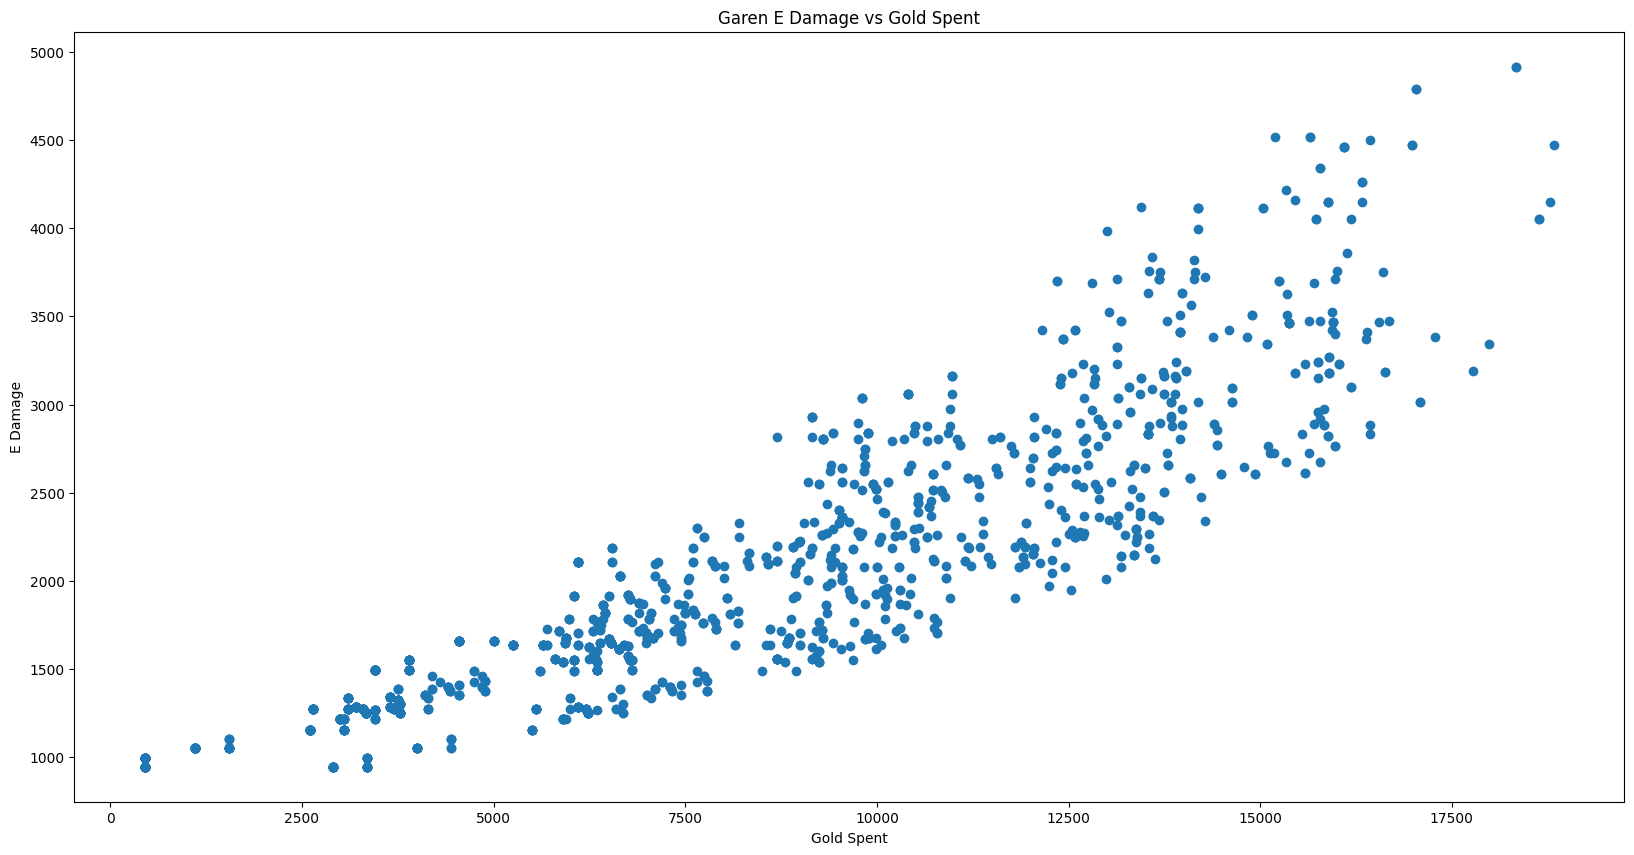

In [19]:
# E damage

items_pool = [
 stride_breaker, beserkers_greaves, dorans_blade, dorans_shield, dead_mans_plate, phantom_dancer, trinity_force,
 black_cleaver, rapid_firecannon, lord_dominiks_regards, infinity_edge]   
results = []

for _ in range(2000):
    num_items = random.randint(1, 6)
    build = random.sample(items_pool, num_items)
    item_types = [item.item_type for item in build if item.item_type is not None]

    if len(item_types) == len(set(item_types)):
        item_name = "_".join([item.name for item in build])
        build_stats = buy_item(garen_stats.iloc[17], build)
        gold = sum([item.price for item in build])
        
        if infinity_edge in build:
            e_turn_near_dmg = e_turn_damage(e_level = 5, stats = build_stats, crit_multiplier = 1.72)[0]
            e_turns = get_total_spins(stats = build_stats)
            e_dmg = e_turn_near_dmg * e_turns
        else:
            e_turn_near_dmg = e_turn_damage(e_level = 5, stats = build_stats)[0]
            e_turns = get_total_spins(stats = build_stats)
            e_dmg = e_turn_near_dmg * e_turns

        results.append({"gold": gold, "e_near_damage": e_dmg, "items": item_name})
    else:
        continue

df_sim = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df_sim['gold'], df_sim['e_near_damage'])

plt.xlabel('Gold Spent')
plt.ylabel('E Damage')
plt.title('Garen E Damage vs Gold Spent')

plt.show()

In [20]:
import plotly.express as px

df_sim['build_display'] = df_sim['items'].str.replace("_", "<br>")

fig = px.scatter(
    df_sim, 
    x="gold", 
    y="e_near_damage",
    color="gold", # Color points by gold spent
    hover_name="e_near_damage", # Title of the tooltip
    hover_data={
        "gold": ":.0f",        # Show gold with 0 decimals
        "e_near_damage": ":.2f",    # Show damage with 2 decimals
        "build_display": True, # Show the item names
        "items": False         # Hide the ugly underscore version
    },
    labels={
        "gold": "Gold Spent",
        "e_near_damage": "Expected E Damage",
        "build_display": "Items"
    },
    title="Interactive Garen Build Analysis: Hover to explore builds",
    template="plotly_dark"
)

# This helps see the optimal path visually
frontier = df_sim.loc[df_sim.groupby(df_sim['gold'] // 200 * 200)['e_near_damage'].idxmax()].sort_values('gold')
fig.add_scatter(
    x=frontier['gold'], 
    y=frontier['e_near_damage'], 
    mode='lines', 
    name='Efficiency Frontier',
    line=dict(color='red', width=2, dash='dot'),
    hoverinfo='skip'
)

fig.show()

### Simple improved model (target dummy)
<ol>
<li>lvl 18, full 5 points in Q and E </li>
<li>can sell boots and doesn't have to buy stride breaker</li>
<li>target with no armor and no magic resistance</li>
<li>** spellblade, energize and % damage increase considered **</li>
</ol>

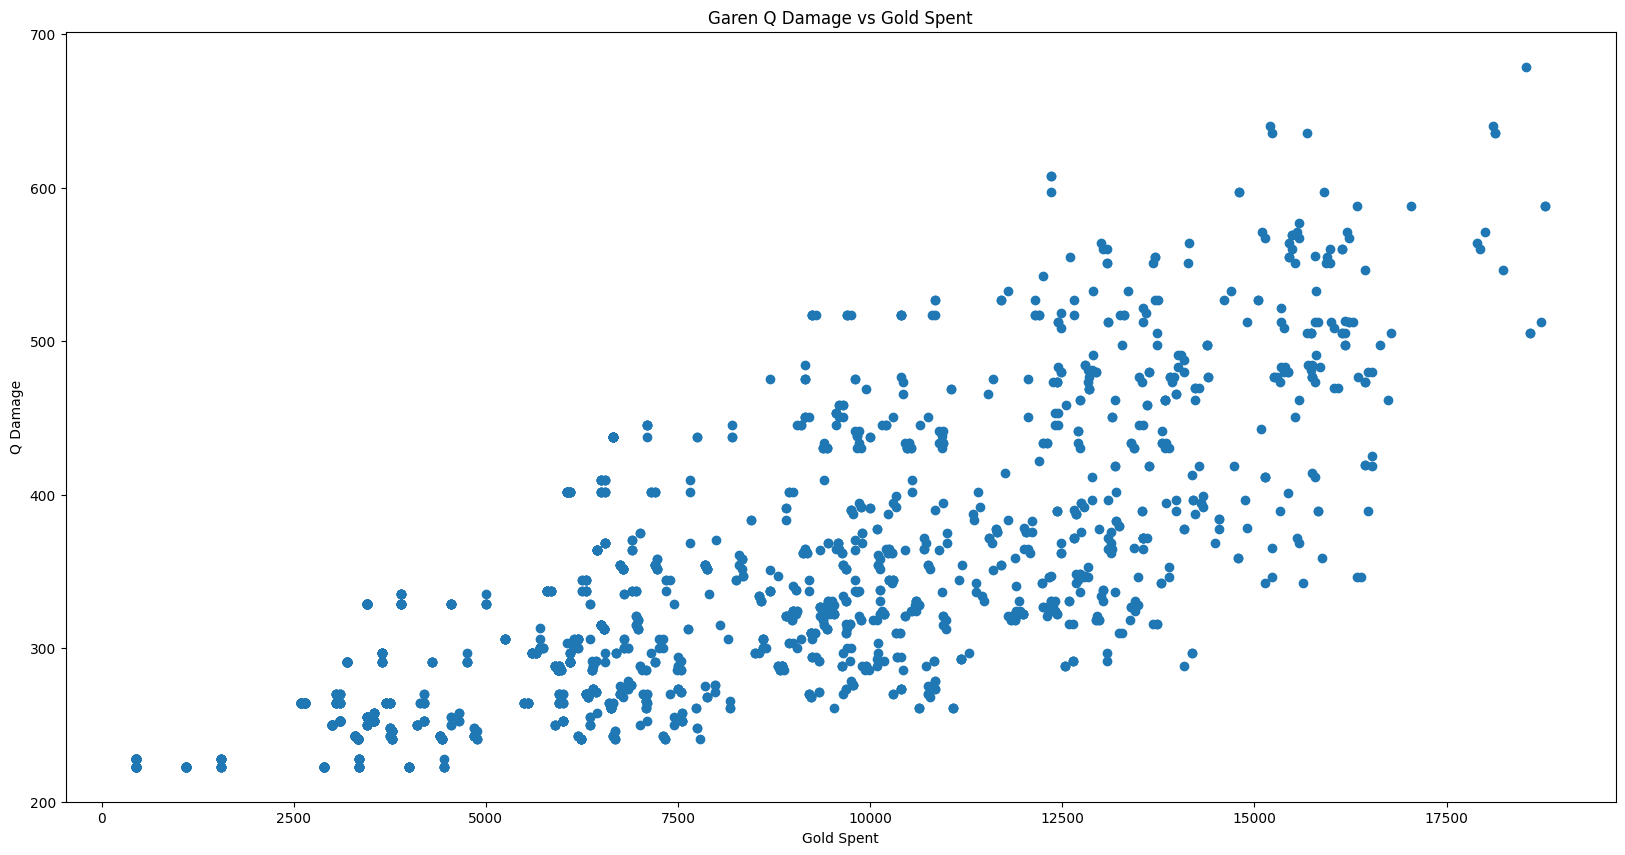

In [21]:
# Q damage
# Garen Level 18 Stats
BASE_AD_L18 = garen_stats.iloc[17]['ad']
items_pool = [
 stride_breaker, beserkers_greaves, dorans_blade, dorans_shield, dead_mans_plate, phantom_dancer, trinity_force,
 black_cleaver, rapid_firecannon, lord_dominiks_regards, infinity_edge, spear_of_shojin]
results = []

for _ in range(3000):
    num_items = random.randint(1, 6)
    build = random.sample(items_pool, num_items)
    item_types = [item.item_type for item in build if item.item_type is not None]

    if len(item_types) == len(set(item_types)):
        item_name = "_".join([item.name for item in build])
        build_stats = buy_item(garen_stats.iloc[17], build)
        gold = sum([item.price for item in build])
        q_dmg = q_damage(
            q_level = 5, 
            stats = build_stats, 
            crit_multiplier = (2.15 if infinity_edge in build else 1.75), # refactored code to reduce if statement operation
            dmg_amp = 1.03 if spear_of_shojin in build else 1,
            )
        # include spellblade and energize
        additional_dmg = (BASE_AD_L18*2 if trinity_force in build else 40 if rapid_firecannon in build else 0)
        results.append({"gold": gold, "q_damage": q_dmg, "items": item_name})
    else:
        continue

df_sim = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df_sim['gold'], df_sim['q_damage'])

plt.xlabel('Gold Spent')
plt.ylabel('Q Damage')
plt.title('Garen Q Damage vs Gold Spent')

plt.show()

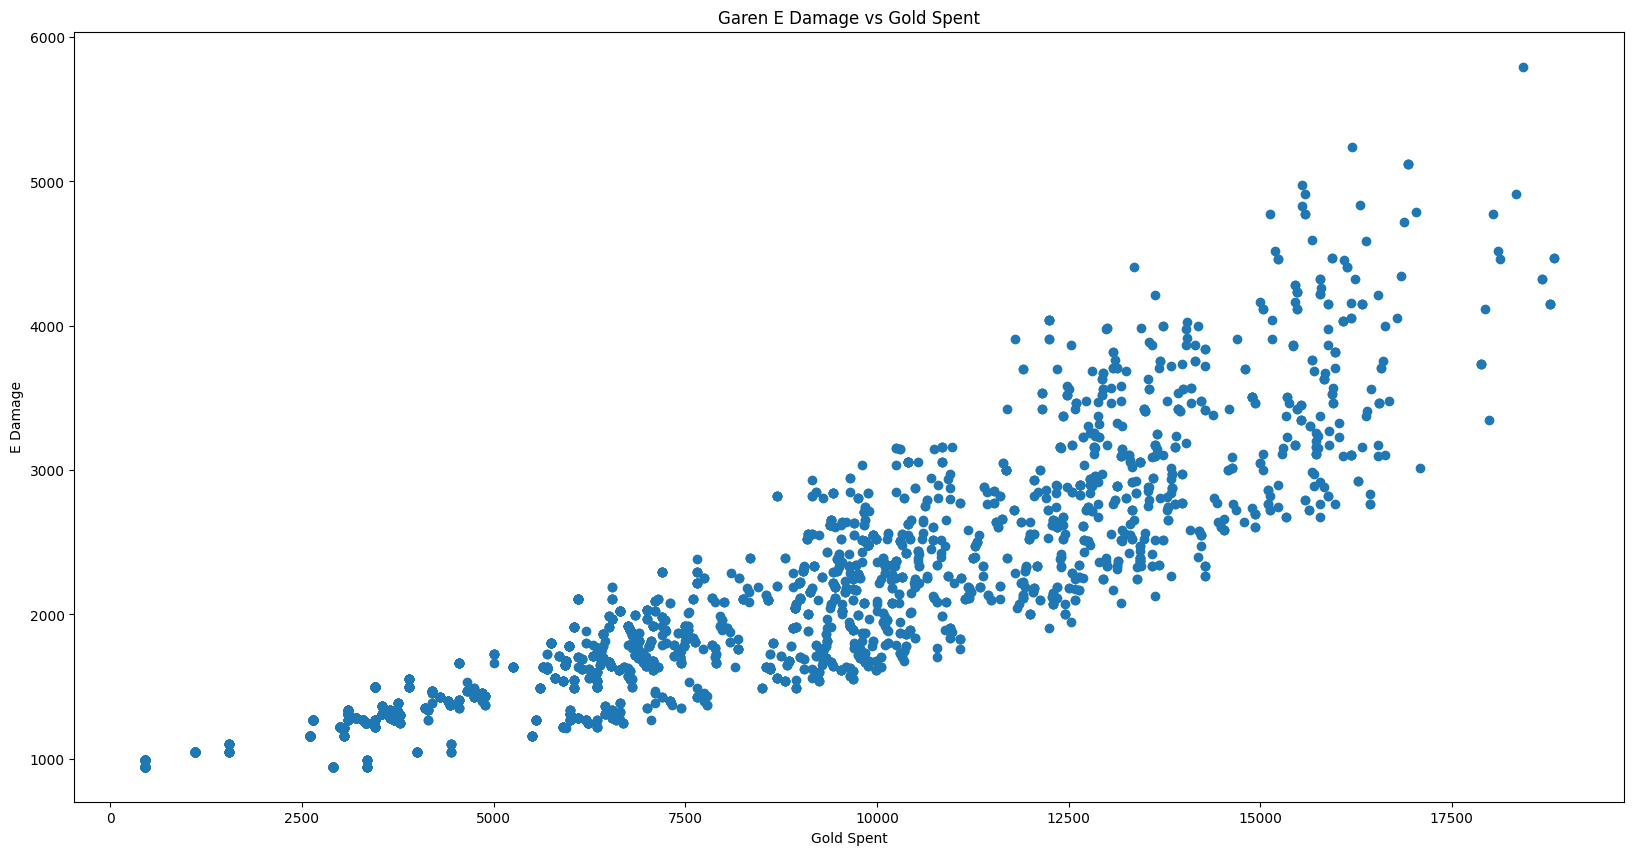

In [22]:
# E damage

items_pool = [
 stride_breaker, beserkers_greaves, dorans_blade, dorans_shield, dead_mans_plate, phantom_dancer, trinity_force,
 black_cleaver, rapid_firecannon, lord_dominiks_regards, infinity_edge, spear_of_shojin]   
results = []

for _ in range(5000):
    num_items = random.randint(1, 6)
    build = random.sample(items_pool, num_items)
    item_types = [item.item_type for item in build if item.item_type is not None]

    if len(item_types) == len(set(item_types)):
        item_name = "_".join([item.name for item in build])
        build_stats = buy_item(garen_stats.iloc[17], build)
        gold = sum([item.price for item in build])
        
        e_turn_near_dmg = e_turn_damage(
            e_level = 5, 
            stats = build_stats, 
            crit_multiplier = (1.72 if infinity_edge in build else 1.4))[0]


        e_turns = get_total_spins(stats = build_stats)
        shojin_amp = 1 + (0.03 * (e_turns - 1) / 2) if spear_of_shojin in build else 1.0
        e_dmg = e_turn_near_dmg * e_turns * shojin_amp

        results.append({"gold": gold, "e_near_damage": e_dmg, "items": item_name})
    else:
        continue

df_sim = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df_sim['gold'], df_sim['e_near_damage'])

plt.xlabel('Gold Spent')
plt.ylabel('E Damage')
plt.title('Garen E Damage vs Gold Spent')

plt.show()

### Combined model (actual target) ###
<ol>
    <li> lvl 18, full 5 points in Q and E </li>
    <li> can sell boots and doesn't have to buy stride breaker </li>
    <li> **target with set amount of armor and magic resistances, typical values taken from adc, fighter and tanks</li>
    <li> combo using q + e</li>
    <li> armor penetration considered</li>
</ol>

## Derivation of a safe ult threshold ##
### Definition ###
Garen calls upon the might of Demacia onto the target enemy Champion,<br>
dealing them true damage as well as revealing them for 1 second at the start of the cast time.<br>
Damage:<br>
150 / 250 / 350 (+ 25 / 30 / 35% of target's missing health)<br>
### Assumptions ###
Given that the damage is true damage, it is not affected by armor or magic resistance. <br>
Assuming that the enemy does not have instantaneous shielding or bone plating (flat reduction to damage received). <br>
Healing received during the cast time of Demacian Justice (0.435 seconds) is negligible. <br>
### Derivation ###
$$D_{\text{Total}} = B + \left( P \times \left( H_{\text{max}} - H_{\text{current}} \right) \right)$$
Where:<br>
$B$: Base Damage,150,300,450 </br>
$P$: Missing Health Ratio,0.25 (25%),0.30 (30%),0.35 (35%)</br>
$H_{\text{max}}$: Target's Maximum Health</br>
$H_{\text{current}}$: Target's Current Health</br>
Via algebraeic manipulation, we can write the safe execution threshold $%T$ as:
$$\%T = \frac{H_{\text{current}}}{H_{\text{max}}} = \frac{\frac{B}{H_{\text{max}}} + P}{1 + P}$$
Take limit of $H_{\text{max}}$ to infinity, which removes the contribution of $\frac{B}{H_{\text{max}}}$:
$$\lim_{H_{\text{max}} \to \infty} \%T = \frac{0 + P}{1 + P} = \frac{P}{1 + P}$$
Yielding the safe execution threshold $\%T$ in terms of $P$, missing health ratio.
### Results ###
Find the safe amount of remaining health to cast each rank of Demacian Justice: <br>
Rank 1: $\frac{0.25}{1 + 0.25} = 0.20$ <br>
Rank 2: $\frac{0.30}{1 + 0.30} = 0.23$ <br>
Rank 3: $\frac{0.35}{1 + 0.35} = 0.26$ <br>